In [47]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.offline
from plotly.subplots import make_subplots
import plotly.express as px
from sklearn.preprocessing import MinMaxScaler

from pptoolbox.platform import preprocess, WAVELENGTHS_3NM_V1
from pptoolbox.preprocessing import SNV, MSC, SavitzkyGolay, Detrend
from pptoolbox.visualization import (plot_spectra, plot_loadings, plot_scree, fit_pca,
                                               generate_pc_df, plot_svp, initialize_theme)

from sklearn.feature_selection import f_classif, mutual_info_classif, chi2

import glob
import pickle

from pptoolbox.visualization import initialize_theme
cmaps = initialize_theme()

In [48]:
label_df = pd.read_csv('../data/processed/label_df_250204.csv')
label_df.head()

,lot_id,lot_name,Brix,T440,T625,TTA,Turbidity,train_test
0,89669,GR 23645201,70.54,87.5,99.8,2.46,0.0,test
1,89670,GR 23645401,70.55,87.5,99.9,2.44,0.0,train
2,89671,GR 23694601,70.72,84.5,96.4,2.43,0.0,train
3,89672,GR 24188801,70.46,86.7,99.9,2.44,0.0,train
4,89673,GR 23444001,70.78,86.9,99.9,2.38,0.0,train


In [49]:
properties_to_compare = list(label_df.select_dtypes(include=[np.number]).columns.drop('lot_id'))
# properties_to_compare.remove('Patulin')
properties_to_compare

['Brix', 'T440', 'T625', 'TTA', 'Turbidity']

# load spectra and preprocess test lots

In [50]:
raw_df = pd.read_csv('../data/raw/spectra_250204.csv')
raw_df.head()

,lot_id,active,analyzer_id,company_id,dark_ref_data,dark_ref_scan_time,date_scanned,detector_temp,frame_data,healthy,...,spectrometer_temp,user_id,version,white_ref_data,white_ref_scan_time,specimen_id,lot_name,analyser_id,product_id,product_name
0,89745,1,56,1086,"[75.75379464285714, 75.11308035714286, 79.0689...",1738155106,1738155515,30.4,False,True,...,36.25,1577,A,"[76.24665178571429, 75.36700892857142, 79.5120...",1738155175,528910,AFP 23273902,56,6773,Apple concentrate (clear)
1,89745,1,56,1086,"[75.75379464285714, 75.11308035714286, 79.0689...",1738155106,1738155550,30.4,False,True,...,36.25,1577,A,"[76.24665178571429, 75.36700892857142, 79.5120...",1738155175,528911,AFP 23273902,56,6773,Apple concentrate (clear)
2,89745,1,56,1086,"[75.75379464285714, 75.11308035714286, 79.0689...",1738155106,1738155581,30.4,False,True,...,36.25,1577,A,"[76.24665178571429, 75.36700892857142, 79.5120...",1738155175,528912,AFP 23273902,56,6773,Apple concentrate (clear)
3,89745,1,56,1086,"[75.75379464285714, 75.11308035714286, 79.0689...",1738155106,1738155640,30.4,False,True,...,36.25,1577,A,"[76.24665178571429, 75.36700892857142, 79.5120...",1738155175,528913,AFP 23273902,56,6773,Apple concentrate (clear)
4,89747,1,56,1086,"[75.75379464285714, 75.11308035714286, 79.0689...",1738155106,1738155791,30.4,False,True,...,36.25,1577,A,"[76.24665178571429, 75.36700892857142, 79.5120...",1738155175,528914,AU 23016501,56,6773,Apple concentrate (clear)


In [51]:
test_label_df = label_df[label_df['train_test'] != 'train']
test_label_df = test_label_df.dropna(axis=1)
test_label_df.shape

(10, 8)

In [52]:
test_label_df['lot_id'].nunique()

10

In [53]:
test_label_df = test_label_df.drop(columns=['lot_name', 'train_test'])
test_spectra,test_label = preprocess(raw_df, test_label_df, wavelengths=WAVELENGTHS_3NM_V1)
test_spectra.shape, test_label.shape

((40, 191), (40, 5))

# loading models

In [54]:
# get names of folders in models directory
models = glob.glob('../models/platform/*')
models

#get last part of file path for model name
model_names = [model.split('\\')[-1] for model in models]
model_names

['6547', '6548']

In [55]:
pkl_files = {}
for model_name in model_names:
    print(model_name)
    pkl_files = {
        **pkl_files,
        model_name : {}
    }
    for property_to_compare in properties_to_compare:
        files = glob.glob(f'../models/platform/{model_name}/prediction/tasteprofile_model_{property_to_compare}.pkl')
        file_path = files[0] if files else None

        pkl_files[model_name] = {
            **pkl_files[model_name],
            f'{property_to_compare}_model' : pickle.load(open(file_path, 'rb')) if file_path else None,
        }

pkl_files

6547
6548


{'6547': {'Brix_model': Pipeline(steps=[('SG2D', SavitzkyGolay(deriv=2, window=15)),
                  ('Scaler', StandardScaler(with_std=False)),
                  ('PLS', PLSRegression(n_components=11, scale=False))]),
  'T440_model': Pipeline(steps=[('SNV', SNV()), ('Scaler', StandardScaler(with_std=False)),
                  ('BayesianRidge',
                   BayesianRidge(alpha_1=56300.27671717498,
                                 alpha_2=56300.27671717498,
                                 lambda_1=24.166882897605,
                                 lambda_2=24.166882897605))]),
  'T625_model': Pipeline(steps=[('SNV', SNV()), ('Scaler', StandardScaler(with_std=False)),
                  ('PCA', PCA(n_components=4, random_state=42)),
                  ('SVR', SVR(C=38.75144945563976, kernel='linear'))]),
  'TTA_model': Pipeline(steps=[('SNV', SNV()), ('Scaler', StandardScaler(with_std=False)),
                  ('BayesianRidge',
                   BayesianRidge(alpha_1=1.1837561727

# predicting

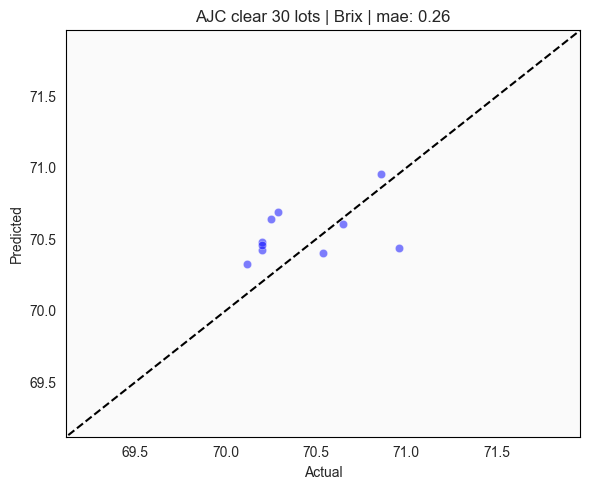

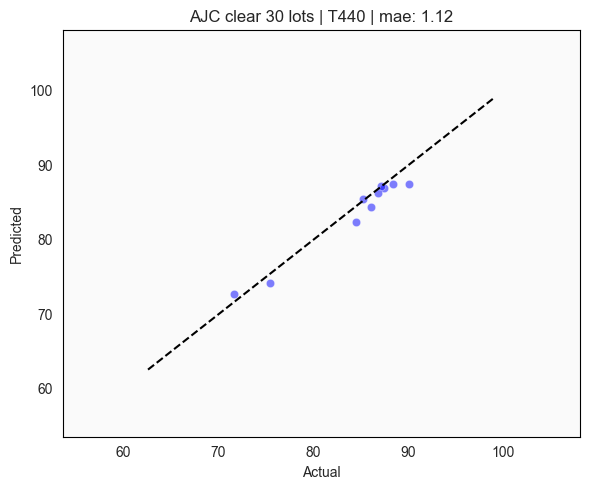

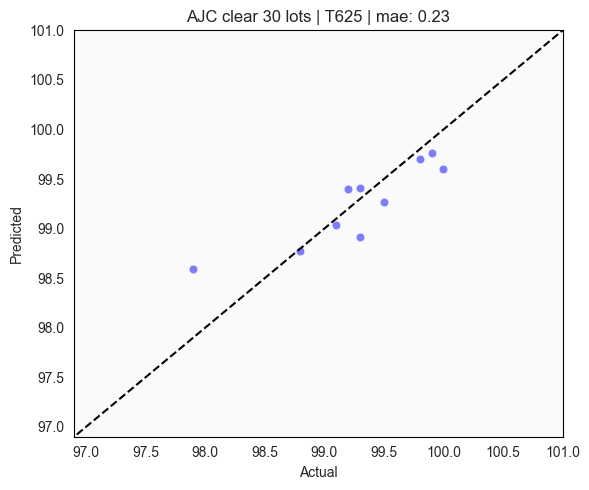

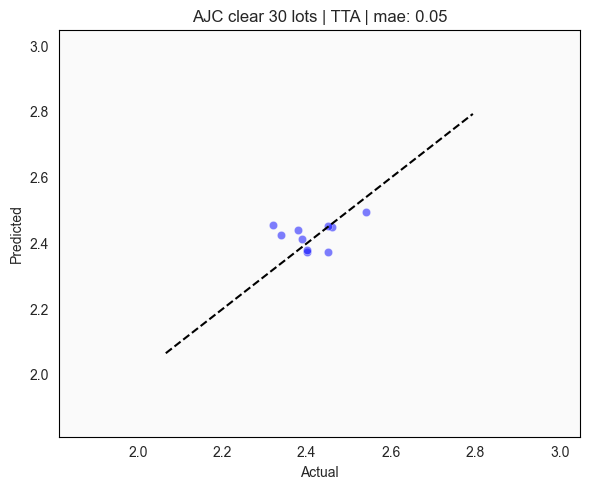

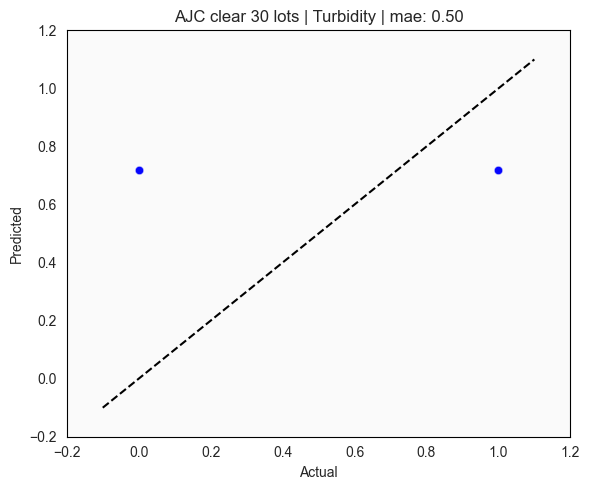

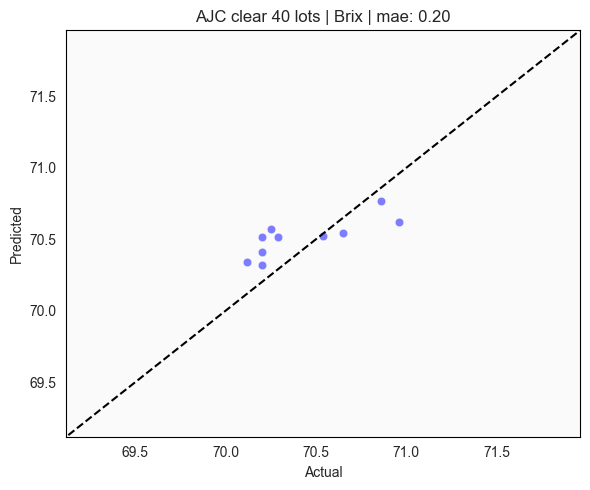

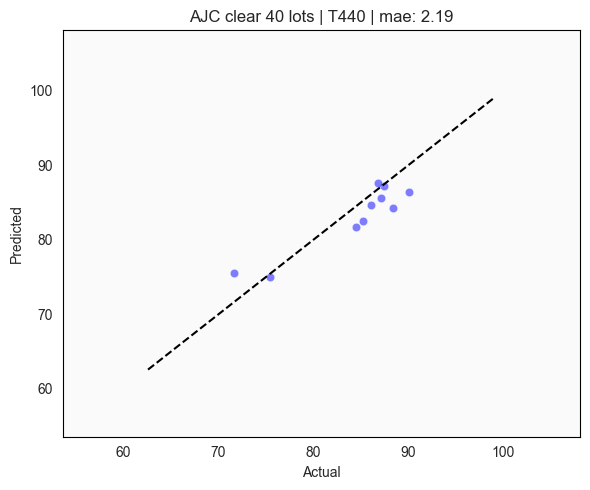

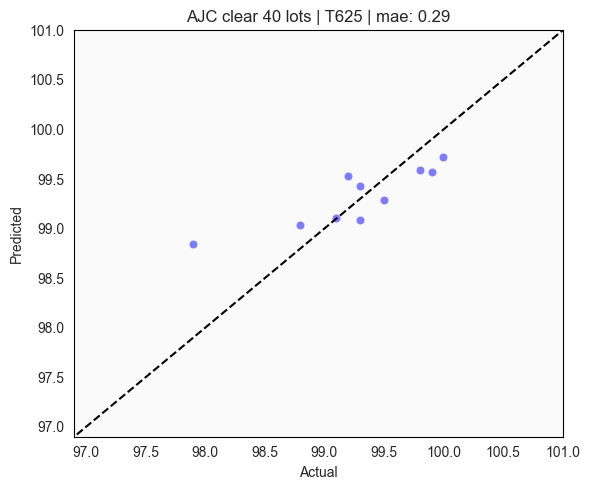

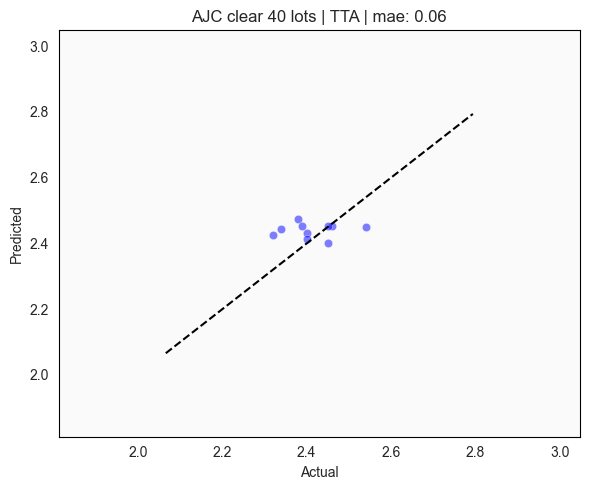

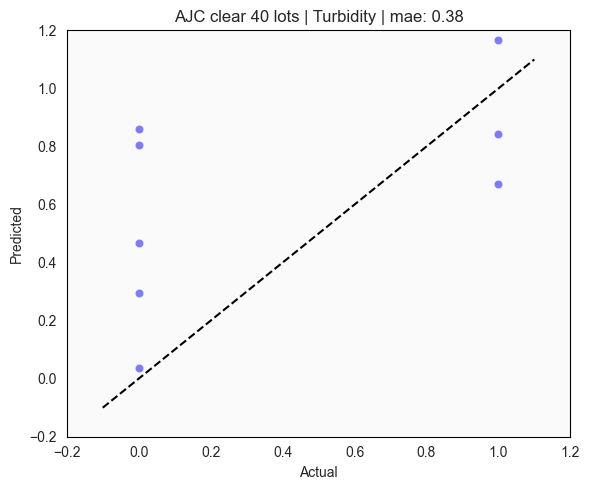

,model_name,property_to_compare,MAE,max_error,R2
0,6547,Brix,0.255657,0.522329,-0.024948
1,6547,T440,1.122188,2.654165,0.941269
2,6547,T625,0.234489,0.690255,0.729111
3,6547,TTA,0.047968,0.135595,-0.038217
4,6547,Turbidity,0.500000,0.719695,-0.193063
5,6548,Brix,0.197738,0.336214,0.399502
6,6548,T440,2.188775,4.142748,0.789492
7,6548,T625,0.289331,0.944795,0.589161
8,6548,TTA,0.056040,0.105950,-0.260960
9,6548,Turbidity,0.382646,0.859084,0.147736


In [64]:
MAE_compiled = pd.DataFrame()

for model_name in model_names:
    for property_to_compare in properties_to_compare:

        my_model = pkl_files[model_name][f'{property_to_compare}_model']
        if my_model:
            grouped_y = np.array(test_label.groupby('lot_id')[property_to_compare].mean())
            grouped_x = test_spectra.groupby('lot_id').mean()
            preds = my_model.predict(grouped_x).ravel()

            #calculate mean absolute error
            mae = np.mean(np.abs(grouped_y - preds))
            max_error = np.max(np.abs(grouped_y - preds))
            R2 = my_model.score(grouped_x, grouped_y)

            MAE_compiled = MAE_compiled.append({
                'model_name':model_name, 
                'property_to_compare':property_to_compare, 
                'MAE':mae,
                'max_error':max_error,
                'R2':R2
                }, ignore_index=True)
            
            plt.figure(figsize=(6, 5))

            if property_to_compare =='Brix' or property_to_compare =='T625':
                plt.xlim(grouped_y.min()-1, grouped_y.max()+1)
                plt.ylim(grouped_y.min()-1, grouped_y.max()+1)
            else:
                plt.xlim(grouped_y.min()-grouped_y.max()*.2, grouped_y.max()+grouped_y.max()*.2)
                plt.ylim(grouped_y.min()-grouped_y.max()*.2, grouped_y.max()+grouped_y.max()*.2)
            sns.scatterplot(x=grouped_y, y=preds, color='blue', alpha=0.5)
            # sns.regplot(x=grouped_y, y=preds, scatter=False, color='blue', ci=None)
            plt.plot([grouped_y.min()-grouped_y.max()*.1, grouped_y.max()+grouped_y.max()*.1], 
                        [grouped_y.min()-grouped_y.max()*.1, grouped_y.max()+grouped_y.max()*.1], 
                        color='black', linestyle='--')  # Reference line
            
            mapping = {
                '6547' : 'AJC clear 30 lots',
                '6548' : 'AJC clear 40 lots',
            }

            model_rename = mapping.get(model_name, model_name)
            
            plt.title(f'{model_rename} | {property_to_compare} | mae: {float(mae):.2f}')
            plt.xlabel(f'Actual')
            plt.ylabel(f'Predicted')

            plt.show()
            plt.close()

MAE_compiled

In [57]:
#obtain range of values of each property in training data
property_ranges = {}
property_ranges['full_range'] = {}
for property_to_compare in properties_to_compare:
    property_ranges['full_range'][property_to_compare] = label_df[property_to_compare].max() - label_df[property_to_compare].min()

In [58]:
property_ranges

{'full_range': {'Brix': 0.8599999999999994,
  'T440': 21.299999999999997,
  'T625': 3.5999999999999943,
  'TTA': 0.2400000000000002,
  'Turbidity': 3.0}}

In [59]:
MAE_compiled

,model_name,property_to_compare,MAE,max_error,R2
0,6547,Brix,0.255657,0.522329,-0.024948
1,6547,T440,1.122188,2.654165,0.941269
2,6547,T625,0.234489,0.690255,0.729111
3,6547,TTA,0.047968,0.135595,-0.038217
4,6547,Turbidity,0.500000,0.719695,-0.193063
5,6548,Brix,0.197738,0.336214,0.399502
6,6548,T440,2.188775,4.142748,0.789492
7,6548,T625,0.289331,0.944795,0.589161
8,6548,TTA,0.056040,0.105950,-0.260960
9,6548,Turbidity,0.382646,0.859084,0.147736


In [60]:
MAE_compiled = MAE_compiled.dropna()


MAE_compiled['full_range'] = MAE_compiled['property_to_compare'].map(lambda x: property_ranges['full_range'][x])

MAE_compiled['MAE_full_range_pct'] = MAE_compiled['MAE'] / MAE_compiled['full_range'] * 100

# map 6547 to AJC clear 30 lots, 6548 to AJC clear 40 lots in model names
MAE_compiled['model_name'] = MAE_compiled['model_name'].map(lambda x: 'AJC clear 30 lots' if '6547' in x else 'AJC clear 40 lots')

MAE_compiled

,model_name,property_to_compare,MAE,max_error,R2,full_range,MAE_full_range_pct
0,AJC clear 30 lots,Brix,0.255657,0.522329,-0.024948,0.86,29.727516
1,AJC clear 30 lots,T440,1.122188,2.654165,0.941269,21.30,5.268488
2,AJC clear 30 lots,T625,0.234489,0.690255,0.729111,3.60,6.513596
3,AJC clear 30 lots,TTA,0.047968,0.135595,-0.038217,0.24,19.986681
4,AJC clear 30 lots,Turbidity,0.500000,0.719695,-0.193063,3.00,16.666667
5,AJC clear 40 lots,Brix,0.197738,0.336214,0.399502,0.86,22.992785
6,AJC clear 40 lots,T440,2.188775,4.142748,0.789492,21.30,10.275938
7,AJC clear 40 lots,T625,0.289331,0.944795,0.589161,3.60,8.036983
8,AJC clear 40 lots,TTA,0.056040,0.105950,-0.260960,0.24,23.350047
9,AJC clear 40 lots,Turbidity,0.382646,0.859084,0.147736,3.00,12.754872


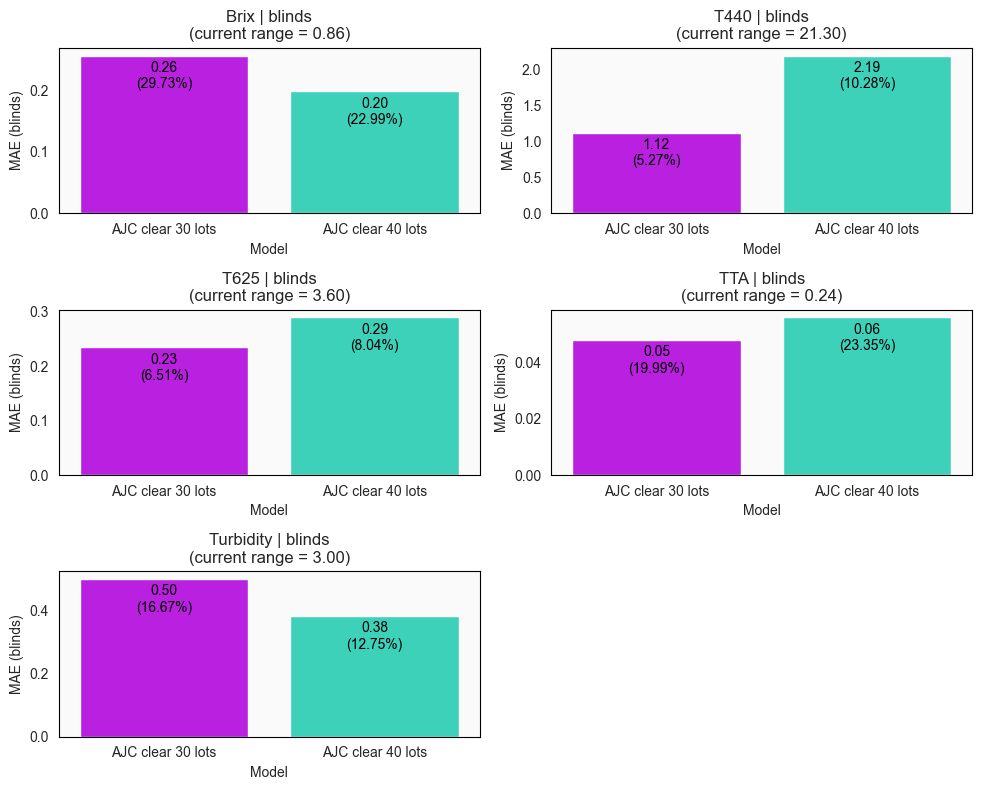

In [61]:
# Get unique properties
properties = MAE_compiled['property_to_compare'].unique()
num_properties = len(properties)

rows, cols = 3, 2
fig, axes = plt.subplots(rows, cols, figsize=(10, 8))

# Flatten axes array for easy indexing
axes = axes.flatten()

# Plot each property in a separate subplot
for i, prop in enumerate(properties):
    ax = axes[i]
    sns.barplot(data=MAE_compiled[MAE_compiled['property_to_compare'] == prop], 
                x='model_name', y='MAE', ax=ax)
    ax.set_title(f'{prop} | blinds\n(current range = {property_ranges["full_range"][prop]:.2f})')
    # ax.set_title(f'{prop}')
    ax.set_xlabel("Model")
    ax.set_ylabel("MAE (blinds)")

    # add labels to the bars
    mae_range = MAE_compiled[MAE_compiled['property_to_compare'] == prop]['MAE_full_range_pct'].values

    for i, value in enumerate(MAE_compiled[MAE_compiled['property_to_compare'] == prop]['MAE']):
        ax.text(i, value - max(MAE_compiled[MAE_compiled['property_to_compare'] == prop]['MAE'])*0.0333, 
                f'{value:.2f}\n({mae_range[i]:.2f}%)', 
                color='black', ha='center', va='top')

#remove empty subplots
for i in range(num_properties, rows*cols):
    fig.delaxes(axes[i])
plt.tight_layout()
plt.show()